In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_distances
from sentence_transformers import SentenceTransformer


In [2]:
df = pd.read_excel("../../data/df_de_final_clustered_bert.xlsx", engine="openpyxl")


In [3]:
df["noise_cluster"] = -99  # -99 = Platzhalter für "nicht im Re-Clustering enthalten"


In [4]:
df_noise = df[df["Cluster_HDBSCAN"] == -1].copy()
print(f"Anzahl Noise-Fragen: {len(df_noise)}")


Anzahl Noise-Fragen: 408


In [5]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')
noise_vectors = model.encode(df_noise["Frage_Text"].tolist(), convert_to_numpy=True, show_progress_bar=True)


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [6]:
dist_matrix = cosine_distances(noise_vectors)


In [18]:
agglo = AgglomerativeClustering(
    n_clusters=None,  # automatischer Cut
    distance_threshold=0.4,  # je kleiner, desto feiner
    metric='precomputed',
    linkage='average'
)
labels = agglo.fit_predict(dist_matrix)
print(f"Anzahl neu gebildeter Cluster: {len(set(labels))}")


Anzahl neu gebildeter Cluster: 236


In [19]:
# Anzahl eindeutiger Cluster
unique_clusters = np.unique(labels)
print(f"Anzahl neu gebildeter Cluster (exkl. Noise): {len(unique_clusters)}")

# Häufigkeit der Clustergrössen
cluster_counts = pd.Series(labels).value_counts().sort_index()
print("\nFragen pro Cluster:")
print(cluster_counts)

Anzahl neu gebildeter Cluster (exkl. Noise): 236

Fragen pro Cluster:
0       3
1      10
2      10
3       5
4       7
       ..
231     1
232     1
233     1
234     1
235     1
Name: count, Length: 236, dtype: int64


In [20]:
# Clusterlabels + Texte zusammenfassen
df_overview = pd.DataFrame({
    "Frage_Text": df_noise["Frage_Text"].tolist(),
    "Cluster": labels
})

def beispiele_anzeigen(df, cluster_ids=None, n=3):
    if cluster_ids is None:
        cluster_ids = df["Cluster"].unique()
    for cid in sorted(cluster_ids):
        fragen = df[df["Cluster"] == cid]["Frage_Text"]
        print(f"\n--- Cluster {cid} ({len(fragen)} Fragen) ---")
        print("\n".join(f"- {f}" for f in fragen.sample(min(n, len(fragen)), random_state=1)))

# Beispiel: zeige 3 Fragen aus den ersten 5 Clustern
beispiele_anzeigen(df_overview, cluster_ids=sorted(df_overview["Cluster"].unique())[10:15])



--- Cluster 10 (2 Fragen) ---
- Aargauer Gemeinden können die Unterbringung von Asylsuchende durch die Entrichtung einer Ersatzabgabe umgehen. Befürworten Sie diese Praxis?
- Sind Sie der Meinung, dass Personen, deren Asylgesuch abgelehnt wurde, nur noch Nothilfe in Form von Naturalien erhalten sollen?

--- Cluster 11 (2 Fragen) ---
- Soll die Netzneutralität (gleichberechtigte Datenübertragung aller Angebote im Internet) per Gesetz verankert werden?
- Soll die Versorgung aller Gemeinden mit schnellem Internet (z.B. Glasfaser) vom Kanton gefördert werden?

--- Cluster 12 (2 Fragen) ---
- Soll auf die vom Bundesrat vorgeschlagene Verschärfung der Zulassungsbedingungen zum Zivildienst verzichtet werden?
- Soll der Bundesrat ein Freihandelsabkommen mit den USA anstreben?

--- Cluster 13 (2 Fragen) ---
- Würden Sie die Einführung der Widerspruchslösung bei der Organspende befürworten?
- Befürworten Sie eine Begrenzung des Pendlerabzugs?

--- Cluster 14 (2 Fragen) ---
- Der Bund möchte ein

In [21]:
import pandas as pd
from collections import Counter
import re

# 1. Nur Noise-Fragen extrahieren
df_noise = df[df["Cluster_HDBSCAN"] == -1].copy()

# 2. Alle Texte zu einem einzigen grossen String verbinden
text_corpus = " ".join(df_noise["Frage_Text"].tolist())

# 3. Tokenisieren (nur Wörter, keine Sonderzeichen oder Zahlen)
tokens = re.findall(r'\b[a-zäöüßA-ZÄÖÜ]{2,}\b', text_corpus)  # nur Wörter mit 2+ Buchstaben

# 4. Alles in Kleinbuchstaben
tokens = [t.lower() for t in tokens]

# 5. Häufigkeitsanalyse
counter = Counter(tokens)
top_20 = counter.most_common(20)

# Ausgabe
print("Top 20 häufigste Wörter in den Noise-Fragen:")
for wort, anzahl in top_20:
    print(f"{wort}: {anzahl}")


Top 20 häufigste Wörter in den Noise-Fragen:
der: 282
die: 235
sie: 191
soll: 140
kanton: 140
für: 132
befürworten: 126
werden: 123
von: 108
und: 101
im: 98
eine: 83
den: 75
in: 74
des: 67
auf: 61
sollen: 60
das: 56
zur: 45
stärker: 42


In [22]:
# Liste der zu entfernenden Wörter (kannst du bei Bedarf manuell anpassen)
stoppwörter = [wort for wort, _ in top_20]

def entferne_stoppwörter(text, stopwords):
    tokens = re.findall(r'\b[a-zäöüßA-ZÄÖÜ]{2,}\b', text)
    tokens = [t for t in tokens if t.lower() not in stopwords]
    return " ".join(tokens)

# Neue Spalte mit bereinigten Texten
df_noise["Frage_Text_cleaned"] = df_noise["Frage_Text"].apply(lambda x: entferne_stoppwörter(x, stoppwörter))


In [23]:
from sentence_transformers import SentenceTransformer

# BERT-Modell laden
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

# Bereinigte Texte in Vektoren umwandeln
texts_cleaned = df_noise["Frage_Text_cleaned"].tolist()
vectors_cleaned = model.encode(texts_cleaned, convert_to_numpy=True, show_progress_bar=True)


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [24]:
from sklearn.metrics.pairwise import cosine_distances

distance_matrix = cosine_distances(vectors_cleaned)


In [36]:
from sklearn.cluster import AgglomerativeClustering

# Clustering konfigurieren
agglo = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0.5,
    metric='precomputed',
    linkage='average'
)

# Clustering ausführen
labels = agglo.fit_predict(distance_matrix)

# Ergebnisse anzeigen
print(f"Anzahl neu gebildeter Cluster: {len(set(labels))}")


Anzahl neu gebildeter Cluster: 225


In [37]:
# Cluster-Labels zu Serie machen
cluster_counts = pd.Series(labels).value_counts().sort_index()

# Ausgabe
print(f"Anzahl neu gebildeter Cluster: {len(cluster_counts)}")
print("\nFragen pro Cluster:")
print(cluster_counts)

Anzahl neu gebildeter Cluster: 225

Fragen pro Cluster:
0      4
1      3
2      2
3      9
4      2
      ..
220    1
221    1
222    1
223    1
224    1
Name: count, Length: 225, dtype: int64


In [39]:
# Neues Vorschau-DataFrame erstellen
df_overview = pd.DataFrame({
    "Frage_Text": df_noise["Frage_Text"],
    "Frage_Text_cleaned": df_noise["Frage_Text_cleaned"],
    "Cluster": labels
})

# Funktion: Beispielfragen anzeigen
def beispiele_anzeigen(df, cluster_ids=None, n=3):
    if cluster_ids is None:
        cluster_ids = df["Cluster"].unique()
    for cid in sorted(cluster_ids):
        fragen = df[df["Cluster"] == cid][["Frage_Text", "Frage_Text_cleaned"]]
        print(f"\n--- Cluster {cid} ({len(fragen)} Fragen) ---")
        for i, row in fragen.sample(min(n, len(fragen)), random_state=1).iterrows():
            print(f"- Original: {row['Frage_Text']}")
            print(f"  Cleaned:  {row['Frage_Text_cleaned']}")

# Beispiel: 3 Fragen aus den ersten 5 Clustern
beispiele_anzeigen(df_overview, cluster_ids=sorted(cluster_counts.index)[:5])



--- Cluster 0 (4 Fragen) ---
- Original: Haben für Sie Steuersenkungen in den Kantonen Nidwalden resp. Obwalden in den nächsten vier Jahren Priorität?
  Cleaned:  Haben Steuersenkungen Kantonen Nidwalden resp Obwalden nächsten vier Jahren Priorität
- Original: Haben für Sie Steuersenkungen in den nächsten fünf Jahren Priorität?
  Cleaned:  Haben Steuersenkungen nächsten fünf Jahren Priorität
- Original: Haben für Sie Steuersenkungen in Lenzburg in den nächsten vier Jahren Priorität?  [Bürger/-innen-Frage]
  Cleaned:  Haben Steuersenkungen Lenzburg nächsten vier Jahren Priorität Bürger innen Frage

--- Cluster 1 (3 Fragen) ---
- Original: Sollen die Vorschriften für den Bau von Wohnraum gelockert werden (z.B. Denkmalschutz, Lärmschutz, Ausnutzungsziffern)?
  Cleaned:  Vorschriften Bau Wohnraum gelockert Denkmalschutz Lärmschutz Ausnutzungsziffern
- Original: Sollen die Vorschriften des eidgenössischen Natur- und Heimatschutzgesetzes gelockert werden?
  Cleaned:  Vorschriften eidgenössi

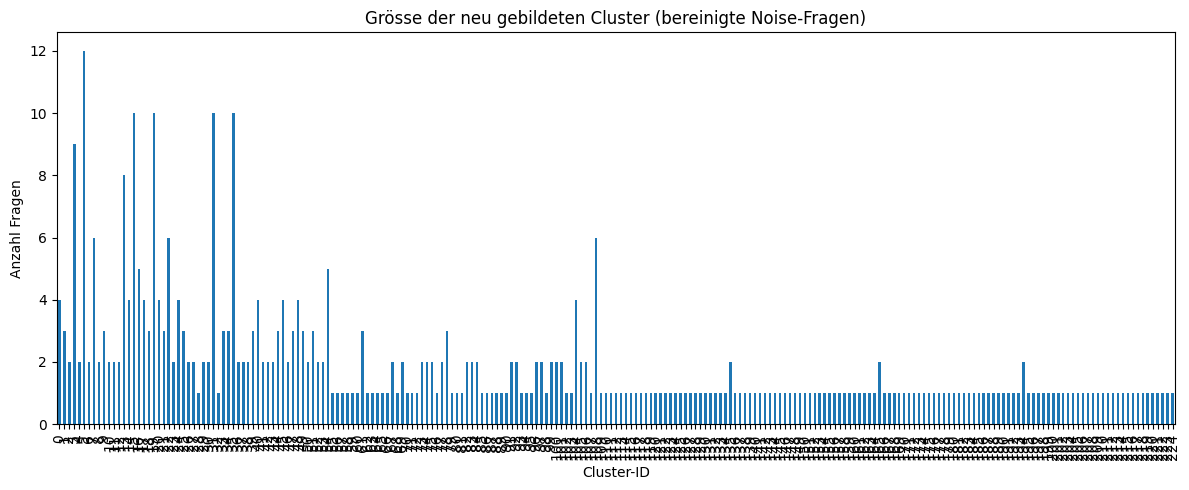

In [40]:
import matplotlib.pyplot as plt

cluster_counts.plot(kind="bar", figsize=(12, 5))
plt.title("Grösse der neu gebildeten Cluster (bereinigte Noise-Fragen)")
plt.xlabel("Cluster-ID")
plt.ylabel("Anzahl Fragen")
plt.tight_layout()
plt.show()


In [41]:
# Neue Clusterlabels zuweisen
df_noise["noise_cluster_cleaned"] = labels


In [42]:
# Werte für die Spalte in df (Haupt-DataFrame)
df.loc[df["Cluster_HDBSCAN"] == -1, "noise_cluster_cleaned"] = df_noise["noise_cluster_cleaned"].values

# Alle anderen behalten den Standardwert (falls noch nicht gesetzt)
df["noise_cluster_cleaned"] = df["noise_cluster_cleaned"].fillna(-99).astype(int)


In [44]:
if "noise_cluster" in df.columns:
    df = df.drop(columns=["noise_cluster"])
    print("Spalte 'noise_cluster' wurde entfernt.")
else:
    print("Spalte 'noise_cluster' existiert nicht oder wurde bereits entfernt.")


Spalte 'noise_cluster' wurde entfernt.


In [46]:
df.to_excel("../../data/df_de_final_clustered_bert_noise_reclustered.xlsx", index=False, engine="openpyxl")
print("Neuer Clusterstatus gespeichert unter: df_de_final_clustered_bert_noise_reclustered.xlsx")


Neuer Clusterstatus gespeichert unter: df_de_final_clustered_bert_noise_reclustered.xlsx
